In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, NHITS, LSTM
from neuralforecast.losses.pytorch import DistributionLoss, Accuracy

In [2]:
prices = pd.read_excel('Final_stoxx600_2015_2023.xlsx', sheet_name='Shares')
prices.columns = [col.replace(' ', '') for col in prices.columns]
# prices.index=pd.to_datetime(prices['Date'])
# prices = prices.drop('Date', axis=1)
prices = prices.drop(prices.index[0]).reset_index(drop=True)
prices.head(2)

,Date,ENXFP,PSPNSE,BOLSS,SOIFP,URWFP,WIEAV,INPSTNA,KPNNA,NEMGY,...,TITIM,NDAGY,HOLMBSS,AMPIM,HELNSE,FHZNSE,SFSNSE,GLENLN,PEOPW,LISPSE
0,2015-01-05,24.106,86.00,127.4,16.633,209.85,11.45,16.0,2.519,7.141,...,0.8500,45.835,134.75,5.025,93.90,134.0,77.1,281.066,173.9,5080
1,2015-01-06,24.192,85.35,127.4,16.633,210.15,11.45,16.0,2.523,7.093,...,0.8575,46.745,134.75,5.025,93.95,132.8,76.2,282.658,173.9,4892


In [3]:
bubble_res_BUB = pd.read_excel('ResultResults_SXXP_2015_2023.xlsx', sheet_name='BUB (CVM= WB, CVQ=95%, L=0)')
bubble_res_BUB['Date']=pd.to_datetime(prices['Date'])
# bubble_res_BUB = bubble_res_BUB.drop('Date', axis=1)
bubble_res_BUB.head(2)

,Date,PSPNSE,BOLSS,SOIFP,URWFP,WIEAV,INPSTNA,KPNNA,NEMGY,CARLBDC,...,TITIM,NDAGY,HOLMBSS,AMPIM,HELNSE,FHZNSE,SFSNSE,GLENLN,PEOPW,LISPSE
0,2015-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-06,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(bubble_res_BUB)

2292

In [109]:
len(bubble_res_BUB)==len(prices)

True

In [110]:
nixtla_df = bubble_res_BUB[['Date','PSPNSE','BOLSS']].melt(var_name='unique_id', id_vars = ['Date'], value_name='y')
nixtla_df =nixtla_df[['unique_id', 'Date', 'y']]
nixtla_df = nixtla_df.rename(columns={'Date': 'ds'})
prices_nixtla = prices[['Date','PSPNSE','BOLSS']].melt(var_name='unique_id', id_vars = ['Date'], value_name='prices')
nixtla_df['prices']=prices_nixtla['prices'].values
# nixtla_df['ds']=prices_nixtla['Date']
nixtla_df['ds']=pd.to_datetime(nixtla_df['ds'])
nixtla_df

,unique_id,ds,y,prices
0,PSPNSE,2015-01-05,0,86.00
1,PSPNSE,2015-01-06,0,85.35
2,PSPNSE,2015-01-07,0,86.75
3,PSPNSE,2015-01-08,0,87.10
4,PSPNSE,2015-01-09,0,88.05
...,...,...,...,...
4579,BOLSS,2023-10-11,0,307.75
4580,BOLSS,2023-10-12,0,306.50
4581,BOLSS,2023-10-13,0,307.95
4582,BOLSS,2023-10-16,0,311.45


In [111]:
# %%capture
horizon = 100

# Try different hyperparmeters to improve accuracy.
models = [MLP(h=horizon,                           # Forecast horizon
              input_size=4 * horizon,              # Length of input sequence
              loss=DistributionLoss('Bernoulli'),  # Binary classification loss
              valid_loss=Accuracy(),               # Accuracy validation signal
              max_steps=500,                       # Number of steps to train
              scaler_type='standard',              # Type of scaler to normalize data
              hidden_size=100,                      # Defines the size of the hidden state of the LSTM
              #early_stop_patience_steps=2,         # Early stopping regularization patience
              val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
              ),
          NHITS(h=horizon,                          # Forecast horizon
                input_size=4 * horizon,             # Length of input sequence
                loss=DistributionLoss('Bernoulli'), # Binary classification loss
                valid_loss=Accuracy(),              # Accuracy validation signal                
                max_steps=500,                      # Number of steps to train
                n_freq_downsample=[2, 1, 1],        # Downsampling factors for each stack output
                #early_stop_patience_steps=2,        # Early stopping regularization patience
                val_check_steps=10,                 # Frequency of validation signal (affects early stopping)
                )             
          ]
nf = NeuralForecast(models=models, freq='B')
Y_hat_df = nf.cross_validation(df=nixtla_df, n_windows=1)


Seed set to 1
Seed set to 1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

In [95]:
# By default NeuralForecast produces forecast intervals
# In this case the lo-x and high-x levels represent the 
# low and high bounds of the prediction accumulating x% probability
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df

,unique_id,ds,cutoff,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90,NHITS,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,prices
0,BOLSS,2023-05-31,2023-05-30,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0,330.45
1,BOLSS,2023-06-01,2023-05-30,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0,336.55
2,BOLSS,2023-06-02,2023-05-30,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0,357.80
3,BOLSS,2023-06-05,2023-05-30,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0,352.20
4,BOLSS,2023-06-06,2023-05-30,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0,352.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,PSPNSE,2023-10-11,2023-05-30,0.100,0.0,0.0,0.0,0.099976,1.0,0.100,0.0,0.0,0.0,0.099976,1.0,0,111.60
196,PSPNSE,2023-10-12,2023-05-30,0.095,0.0,0.0,0.0,0.000000,1.0,0.094,0.0,0.0,0.0,0.000000,1.0,0,111.20
197,PSPNSE,2023-10-13,2023-05-30,0.107,0.0,0.0,0.0,1.000000,1.0,0.107,0.0,0.0,0.0,1.000000,1.0,0,110.30
198,PSPNSE,2023-10-16,2023-05-30,0.112,0.0,0.0,0.0,1.000000,1.0,0.105,0.0,0.0,0.0,1.000000,1.0,0,110.40


In [99]:
# Define classification threshold for final predictions
# If (prob > threshold) -> 1
Y_hat_df['NHITS'] = (Y_hat_df['NHITS'] > 0.5) * 1
Y_hat_df['MLP'] = (Y_hat_df['MLP'] > 0.5) * 1
Y_hat_df

,unique_id,ds,cutoff,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90,NHITS,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,prices
0,BOLSS,2023-05-31,2023-05-30,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0.0,0,330.45
1,BOLSS,2023-06-01,2023-05-30,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0.0,0,336.55
2,BOLSS,2023-06-02,2023-05-30,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0.0,0,357.80
3,BOLSS,2023-06-05,2023-05-30,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0.0,0,352.20
4,BOLSS,2023-06-06,2023-05-30,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0.000000,0.0,0,352.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,PSPNSE,2023-10-11,2023-05-30,0,0.0,0.0,0.0,0.099976,1.0,0,0.0,0.0,0.0,0.099976,1.0,0,111.60
196,PSPNSE,2023-10-12,2023-05-30,0,0.0,0.0,0.0,0.000000,1.0,0,0.0,0.0,0.0,0.000000,1.0,0,111.20
197,PSPNSE,2023-10-13,2023-05-30,0,0.0,0.0,0.0,1.000000,1.0,0,0.0,0.0,0.0,1.000000,1.0,0,110.30
198,PSPNSE,2023-10-16,2023-05-30,0,0.0,0.0,0.0,1.000000,1.0,0,0.0,0.0,0.0,1.000000,1.0,0,110.40


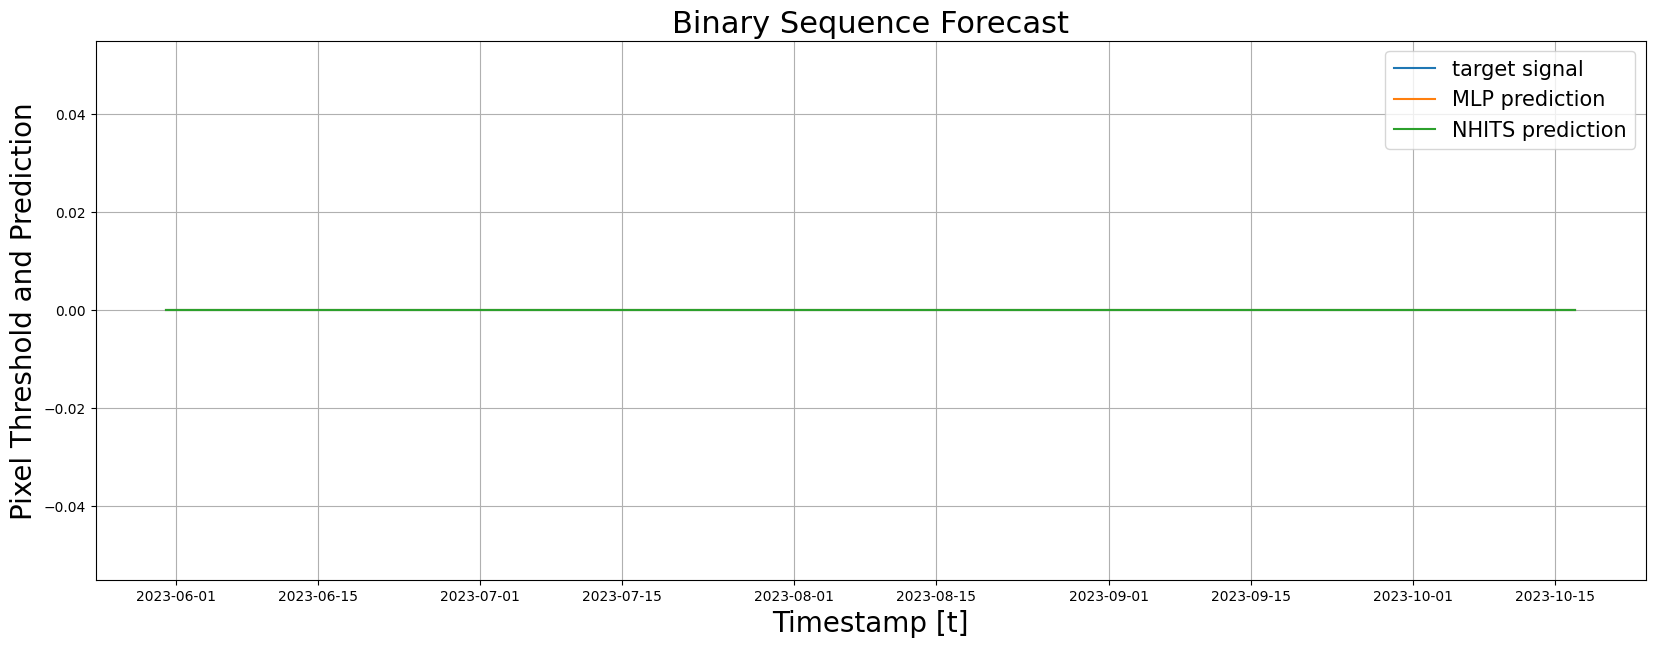

In [97]:
plot_df = Y_hat_df[Y_hat_df.unique_id=='BOLSS']

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plt.plot(plot_df.ds, plot_df.y, label='target signal')
plt.plot(plot_df.ds, plot_df['MLP'] * 1.1, label='MLP prediction')
plt.plot(plot_df.ds, plot_df['NHITS'] * .9, label='NHITS prediction')
ax.set_title('Binary Sequence Forecast', fontsize=22)
ax.set_ylabel('Pixel Threshold and Prediction', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [98]:
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

mlp_acc = accuracy(y=Y_hat_df['y'], y_hat=Y_hat_df['MLP'])
nhits_acc = accuracy(y=Y_hat_df['y'], y_hat=Y_hat_df['NHITS'])

print(f'MLP Accuracy: {mlp_acc:.1%}')
print(f'NHITS Accuracy: {nhits_acc:.1%}')

MLP Accuracy: 100.0%
NHITS Accuracy: 100.0%


## De lucru:
- Folosim numai companiile pentru care avem 6 bubbles (mediana nr de bubbles).
- Alegem intervalele de timp
      - rolling windows de mai multe dimensiuni: 100, 150, 200, 250
      - horizon sa fie de dimensiune egala cu mediana nr de zile din bule - adica 24 de zile (mai putem experimenta si altele)
      - lasam deoparte (in test) ultimul an, adica 2023. Pentru 2023 trebuie sa vedem cat de multe bubbles avem...
- Folosim Time Series scaling (toata seria si separat cu temporal window normalization)
- Calculam features:
      - aplicam tsfresh cu rolling (https://tsfresh.readthedocs.io/en/latest/text/forecasting.html)
- De vazut ce alte modele pot fi folosite

In [112]:
bubble_res_comp_6_bubbles = pd.read_pickle('bubble_res_comp_6_bubbles.pkl')
bubble_res_comp_6_bubbles

,Firm,Start,Peak,End,Duration,Boom Phase,Burst Phase
10,SOIFP,401,893,934,534,492,42
11,SOIFP,1115,1122,1131,17,7,10
12,SOIFP,1159,1171,1176,18,12,6
13,SOIFP,1261,1278,1279,19,17,2
14,SOIFP,1499,1507,1513,15,8,7
...,...,...,...,...,...,...,...
3308,HOLMBSS,730,796,801,72,66,6
3309,HOLMBSS,828,862,863,36,34,2
3310,HOLMBSS,1219,1220,1226,8,1,7
3311,HOLMBSS,1244,1339,1344,101,95,6


In [114]:
ind_2023 = prices[prices['Date']>'2023-01-01'].index
ind_2022 = prices[prices['Date']>'2022-01-01'].index
ind_2021 = prices[prices['Date']>'2021-01-01'].index
ind_2020 = prices[prices['Date']>'2020-01-01'].index
ind_2019 = prices[prices['Date']>'2019-01-01'].index
ind_2018 = prices[prices['Date']>'2018-01-01'].index
ind_2017 = prices[prices['Date']>'2017-01-01'].index
ind_2016 = prices[prices['Date']>'2016-01-01'].index

In [115]:
bubble_res_comp_6_bubbles_2023 = bubble_res_comp_6_bubbles[bubble_res_comp_6_bubbles['Start']>=ind_2023[0]]
print('2023:'+str(len(bubble_res_comp_6_bubbles_2023['Firm'].value_counts())))

2023:31


In [118]:
comps_6bubs = bubble_res_comp_6_bubbles['Firm'].unique()
comps_6bubs = np.insert(comps_6bubs, 0, 'Date')
comps_6bubs

array(['Date', 'SOIFP', 'PKNPW', 'PHIANA', 'REPSQ', 'TEFSQ', 'CSFP',
       'LXILN', 'RFFP', 'SAFFP', 'MTXGY', 'AEDBB', 'INDTSS', 'ADPFP',
       'KINDSDBSS', 'FORTUMFH', 'IPNFP', 'TENIM', 'BIMFP', 'CABKSQ',
       'AKRBPNO', 'ESSITYBSS', 'VALMTFH', 'AXFOSS', 'EVKGY', 'ERFFP',
       'NEXIIM', 'GAWLN', 'RILBADC', 'SPLPW', 'COLSQ', 'STLAMIM',
       'BATSLN', 'ALVGY', 'DBKGY', 'BASGY', 'HEN3GY', 'VOW3GY', 'SAPGY',
       'TKAGY', 'DB1GY', 'CONGY', 'INCHLN', 'SALMNO', 'MKSLN', 'PSNLN',
       'CDIFP', 'VIVFP', 'PUBFP', 'TOPDC', 'RNOFP', 'FRFP', 'SWECBSS',
       'EKTABSS', 'RHMGY', 'BRBYLN', 'CPGLN', 'ITVLN', 'CRDALN', 'GALESE',
       'BWYLN', 'INDUCSS', 'HSBALN', 'SGROLN', 'SBRYLN', 'PNNLN', 'VNAGY',
       'FDJFP', 'WEIRLN', 'BUCNSE', 'TIGOSS', 'ANDRAV', 'CNHIIM',
       'SRT3GY', 'CCHLN', 'CHRDC', 'EQNRNO', 'AENASQ', 'OMVAV', 'JMATLN',
       'CNALN', 'SKFBSS', 'TRELBSS', 'DANSKEDC', 'SCABSS', 'ROCKBDC',
       'CLNSE', 'HOLNSE', 'LONNSE', 'UPMFH', 'LRFP', 'SLHNSE', 'COFBBB',
       

In [125]:
bubble_res_BUB_6bubs = bubble_res_BUB[comps_6bubs]
bubble_res_BUB_6bubs_ex2023 = bubble_res_BUB_6bubs[bubble_res_BUB_6bubs['Date']<'2023-01-01']
bubble_res_BUB_6bubs_ex2023.tail(2)

,Date,SOIFP,PKNPW,PHIANA,REPSQ,TEFSQ,CSFP,LXILN,RFFP,SAFFP,...,SCABSS,ROCKBDC,CLNSE,HOLNSE,LONNSE,UPMFH,LRFP,SLHNSE,COFBBB,HOLMBSS
2083,2022-12-29,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2084,2022-12-30,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
prices_6bubs = prices[comps_6bubs]
prices_6bubs_ex2023 = prices_6bubs[prices_6bubs['Date']<'2023-01-01']
prices_6bubs_ex2023.tail(2)

,Date,SOIFP,PKNPW,PHIANA,REPSQ,TEFSQ,CSFP,LXILN,RFFP,SAFFP,...,SCABSS,ROCKBDC,CLNSE,HOLNSE,LONNSE,UPMFH,LRFP,SLHNSE,COFBBB,HOLMBSS
2083,2022-12-29,155.55,64.50,13.6618,14.985,3.446,26.400,114.2,59.0,118.02,...,134.80,1640.5,14.83,48.12,461.2,35.15,76.28,481.2,84.15,419.4
2084,2022-12-30,152.85,64.24,13.4053,14.850,3.385,26.055,112.6,58.1,116.92,...,131.95,1633.0,14.65,47.88,453.1,34.93,74.82,476.8,83.70,413.9


In [154]:
nixtla_df_6bubs_ex2023 = bubble_res_BUB_6bubs_ex2023[comps_6bubs].melt(var_name='unique_id', id_vars = ['Date'], value_name='y')
nixtla_df_6bubs_ex2023 =nixtla_df_6bubs_ex2023[['unique_id', 'Date', 'y']]
nixtla_df_6bubs_ex2023 = nixtla_df_6bubs_ex2023.rename(columns={'Date': 'ds'})
prices_nixtla_6bubs_ex2023 = prices_6bubs_ex2023[comps_6bubs].melt(var_name='unique_id', id_vars = ['Date'], value_name='prices')
nixtla_df_6bubs_ex2023['prices']=prices_nixtla_6bubs_ex2023['prices'].values
# nixtla_df['ds']=prices_nixtla['Date']
nixtla_df_6bubs_ex2023['ds']=pd.to_datetime(nixtla_df_6bubs_ex2023['ds'])
nixtla_df_6bubs_ex2023.head(2)

,unique_id,ds,y,prices
0,SOIFP,2015-01-05,0,16.633
1,SOIFP,2015-01-06,0,16.633


In [139]:
import pandas as pd
df = pd.DataFrame({
   "id": [1, 1, 1, 1, 2, 2],
   "time": [1, 2, 3, 4, 8, 9],
   "x": [1, 2, 3, 4, 10, 11],
   "y": [5, 6, 7, 8, 12, 13],
})
df

,id,time,x,y
0,1,1,1,5
1,1,2,2,6
2,1,3,3,7
3,1,4,4,8
4,2,8,10,12
5,2,9,11,13


In [142]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(df, column_id="id", column_sort="time", max_timeshift=1, min_timeshift=1)

Rolling: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


In [143]:
df_rolled

,id,time,x,y
0,"(1, 2)",1,1,5
1,"(1, 2)",2,2,6
4,"(1, 3)",2,2,6
5,"(1, 3)",3,3,7
6,"(1, 4)",3,3,7
7,"(1, 4)",4,4,8
2,"(2, 9)",8,10,12
3,"(2, 9)",9,11,13


In [ ]:
df_rolled = roll_time_series(df, column_id="id", column_sort="time", max_timeshift=1, min_timeshift=1)

In [144]:
nixtla_df_6bubs_ex2023['unique_id'].unique()

array(['SOIFP', 'PKNPW', 'PHIANA', 'REPSQ', 'TEFSQ', 'CSFP', 'LXILN',
       'RFFP', 'SAFFP', 'MTXGY', 'AEDBB', 'INDTSS', 'ADPFP', 'KINDSDBSS',
       'FORTUMFH', 'IPNFP', 'TENIM', 'BIMFP', 'CABKSQ', 'AKRBPNO',
       'ESSITYBSS', 'VALMTFH', 'AXFOSS', 'EVKGY', 'ERFFP', 'NEXIIM',
       'GAWLN', 'RILBADC', 'SPLPW', 'COLSQ', 'STLAMIM', 'BATSLN', 'ALVGY',
       'DBKGY', 'BASGY', 'HEN3GY', 'VOW3GY', 'SAPGY', 'TKAGY', 'DB1GY',
       'CONGY', 'INCHLN', 'SALMNO', 'MKSLN', 'PSNLN', 'CDIFP', 'VIVFP',
       'PUBFP', 'TOPDC', 'RNOFP', 'FRFP', 'SWECBSS', 'EKTABSS', 'RHMGY',
       'BRBYLN', 'CPGLN', 'ITVLN', 'CRDALN', 'GALESE', 'BWYLN', 'INDUCSS',
       'HSBALN', 'SGROLN', 'SBRYLN', 'PNNLN', 'VNAGY', 'FDJFP', 'WEIRLN',
       'BUCNSE', 'TIGOSS', 'ANDRAV', 'CNHIIM', 'SRT3GY', 'CCHLN', 'CHRDC',
       'EQNRNO', 'AENASQ', 'OMVAV', 'JMATLN', 'CNALN', 'SKFBSS',
       'TRELBSS', 'DANSKEDC', 'SCABSS', 'ROCKBDC', 'CLNSE', 'HOLNSE',
       'LONNSE', 'UPMFH', 'LRFP', 'SLHNSE', 'COFBBB', 'HOLMBSS'],
   

In [148]:
nixtla_df_6bubs_ex2023_test =nixtla_df_6bubs_ex2023[nixtla_df_6bubs_ex2023['unique_id'].isin(['SOIFP', 'PKNPW'])]
nixtla_df_6bubs_ex2023_test.columns = ['id', 'time', 'y', 'prices']
nixtla_df_6bubs_ex2023_test = nixtla_df_6bubs_ex2023_test.drop('y', axis=1)
nixtla_df_6bubs_ex2023_test

,id,time,prices
0,SOIFP,2015-01-05,16.6330
1,SOIFP,2015-01-06,16.6330
2,SOIFP,2015-01-07,16.1532
3,SOIFP,2015-01-08,16.4731
4,SOIFP,2015-01-09,16.4731
...,...,...,...
4165,PKNPW,2022-12-26,63.7000
4166,PKNPW,2022-12-27,63.7200
4167,PKNPW,2022-12-28,63.6200
4168,PKNPW,2022-12-29,64.5000


In [150]:
df_rolled_test = roll_time_series(nixtla_df_6bubs_ex2023_test, column_id="id", column_sort="time", max_timeshift=99, min_timeshift=99)
# df_rolled_test.to_excel('df_rolled_test.xlsx')
df_rolled_test.head()

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.56it/s]


,id,time,prices
0,"(PKNPW, 2015-05-22 00:00:00)",2015-01-05,47.75
1,"(PKNPW, 2015-05-22 00:00:00)",2015-01-06,47.75
2,"(PKNPW, 2015-05-22 00:00:00)",2015-01-07,49.94
3,"(PKNPW, 2015-05-22 00:00:00)",2015-01-08,51.30
4,"(PKNPW, 2015-05-22 00:00:00)",2015-01-09,51.27


In [151]:
from tsfresh import extract_features
df_features_test = extract_features(df_rolled_test, column_id="id", column_sort="time")
df_features_test.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


prices__variance_larger_than_standard_deviation  \
PKNPW 2015-05-22                                              1.0   
      2015-05-25                                              1.0   
      2015-05-26                                              1.0   
      2015-05-27                                              1.0   
      2015-05-28                                              1.0   

                  prices__has_duplicate_max  prices__has_duplicate_min  \
PKNPW 2015-05-22                        0.0                        1.0   
      2015-05-25                        0.0                        0.0   
      2015-05-26                        0.0                        0.0   
      2015-05-27                        0.0                        0.0   
      2015-05-28                        0.0                        0.0   

                  prices__has_duplicate  prices__sum_values  \
PKNPW 2015-05-22                    1.0             5880.61   
      2015-05-25                    1.0             5903.36   
      2015-05-26                    1.0             5927.16   
      2015-05-27                    1.0             5950.12   
      2015-05-28                    1.0             5971.52   

                  prices__abs_energy  prices__mean_abs_change  \
PKNPW 2015-05-22         350061.5503                 0.927273   
      2015-05-25         352751.7378                 0.942929   
      2015-05-26         355591.0778                 0.931414   
      2015-05-27         358411.4842                 0.931313   
      2015-05-28         361065.0842                 0.933030   

                  prices__mean_change  prices__mean_second_derivative_central  \
PKNPW 2015-05-22             0.245455                               -0.002296   
      2015-05-25             0.229798                               -0.019082   
      2015-05-26             0.218283                               -0.001582   
      2015-05-27             0.218182                                0.007041   
      2015-05-28             0.216465                               -0.001939   

                  prices__median  ...  prices__fourier_entropy__bins_5  \
PKNPW 2015-05-22          56.450  ...                         0.192626   
      2015-05-25          56.475  ...                         0.192626   
      2015-05-26          56.500  ...                         0.192626   
      2015-05-27          56.500  ...                         0.192626   
      2015-05-28          56.750  ...                         0.192626   

                  prices__fourier_entropy__bins_10  \
PKNPW 2015-05-22                          0.192626   
      2015-05-25                          0.192626   
      2015-05-26                          0.192626   
      2015-05-27                          0.192626   
      2015-05-28                          0.192626   

                  prices__fourier_entropy__bins_100  \
PKNPW 2015-05-22                           0.668811   
      2015-05-25                           0.602410   
      2015-05-26                           0.612670   
      2015-05-27                           0.545824   
      2015-05-28                           0.478541   

                  prices__permutation_entropy__dimension_3__tau_1  \
PKNPW 2015-05-22                                         1.647320   
      2015-05-25                                         1.656336   
      2015-05-26                                         1.669054   
      2015-05-27                                         1.656336   
      2015-05-28                                         1.657265   

                  prices__permutation_entropy__dimension_4__tau_1  \
PKNPW 2015-05-22                                         2.746174   
      2015-05-25                                         2.760242   
      2015-05-26                                         2.758515   
      2015-05-27                                         2.754713   
      2015-05-28                        

In [153]:
df_features_test.columns

Index(['prices__variance_larger_than_standard_deviation',
       'prices__has_duplicate_max', 'prices__has_duplicate_min',
       'prices__has_duplicate', 'prices__sum_values', 'prices__abs_energy',
       'prices__mean_abs_change', 'prices__mean_change',
       'prices__mean_second_derivative_central', 'prices__median',
       ...
       'prices__fourier_entropy__bins_5', 'prices__fourier_entropy__bins_10',
       'prices__fourier_entropy__bins_100',
       'prices__permutation_entropy__dimension_3__tau_1',
       'prices__permutation_entropy__dimension_4__tau_1',
       'prices__permutation_entropy__dimension_5__tau_1',
       'prices__permutation_entropy__dimension_6__tau_1',
       'prices__permutation_entropy__dimension_7__tau_1',
       'prices__query_similarity_count__query_None__threshold_0.0',
       'prices__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [ ]:
roll_win = 100
hor = 24 #mediana nr de zile cu bubbles
